# Using Y-factor to infer $T_{50 \Omega}$ of the blackbodies and noise diodes

Assuming our sources are perfect 50 $\Omega$ loads, we can use the hot-cold method to infer their effective noise temperature, assuming a linear response of power spectrum measured by the system (LNA and SA) to the input noise power. This procedure usually does not require a second-stage amplifier.

In [42]:
# import necessary modules
import os
from os.path import join as pjoin
import numpy as np
import skrf as rf
from matplotlib import pyplot as plt

pjoin = os.path.join
pbase = os.path.basename

%load_ext autoreload
%autoreload 2

# import relevant classes from highz_exp
from highz_exp.fit_temperature import Y_Factor_Thermometer
from highz_exp.s_params import S_Params
from highz_exp.spec_class import Spectrum
from highz_exp import plotter

# set up data paths
data_path = os.path.expanduser("~/Desktop/High-Z/SA_Measurements") # change this to your data directory
output_path = pjoin(data_path, 'Processed') # change this to your desired output directory
plot_path = pjoin(data_path, 'Plots') # change this to your desired plot directory
sparam_path = os.path.expanduser("~/Desktop/High-Z/S21Measurements") # change this to your S-parameter data directory

if os.path.exists(output_path) is False:
    os.makedirs(output_path)
if os.path.exists(plot_path) is False:
    os.makedirs(plot_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# Import data loading module, this is used to parse CSV files from Keysight spectrum analyzer.
from highz_exp import load_csv

# load data for 300K-77K measurements
file_LNA = pjoin(data_path, 'LNA02_HF.csv')
load_csv.split_csv_by_trace_name(file_LNA, 
                                 header_file=pjoin(output_path, 'LNA02_HF_header.csv'),
                                 data_file= pjoin(output_path, 'LNA02_HF_data.csv'))

# parse data files into separate traces
traces_LNA = load_csv.parse_trace_data(pjoin(output_path, 'LNA02_HF_data.csv'))
LNA02_BB016 = Spectrum(traces_LNA['Trace A']['frequency'], traces_LNA['Trace A']['spectrum'], 
                      name='BB016')
LNA02_ND01 = Spectrum(traces_LNA['Trace B']['frequency'], traces_LNA['Trace B']['spectrum'], 
                       name='ND01')
LNA02_300K = Spectrum(traces_LNA['Trace C']['frequency'], traces_LNA['Trace C']['spectrum'], 
                       name='300K load')
LNA02_77K = Spectrum(traces_LNA['Trace D']['frequency'], traces_LNA['Trace D']['spectrum'], 
                     name='77K load')

Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/LNA02_HF_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/LNA02_HF_data.csv (755 rows)
Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 751 data points
Successfully parsed 4 traces with data


In [44]:
# Despike all spectra using a median filter with a window size of 31
LNA02_300K.despike(window=21, threshold=1, replace='median', inplace=True)
LNA02_77K.despike(window=21, threshold=1, replace='median', inplace=True)
LNA02_BB016.despike(window=21, threshold=1, replace='median', inplace=True)
LNA02_ND01.despike(window=21, threshold=1, replace='median', inplace=True)


<Spectrum name='ND01' points=751 metadata_keys=[]>

In [ ]:
LNA02_300K.smooth()

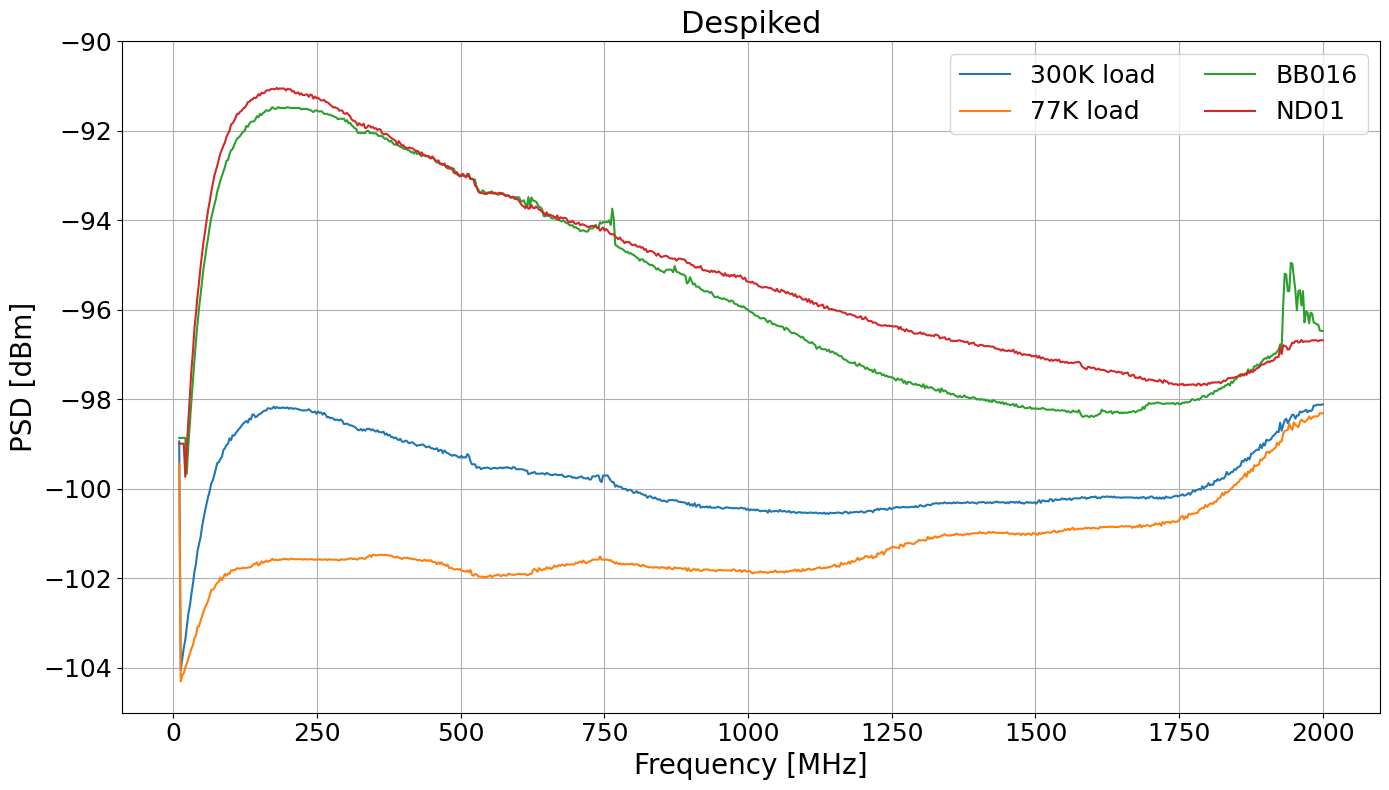

In [30]:
plotter.plot_spectra([LNA02_300K, LNA02_77K, LNA02_BB016, LNA02_ND01], 
                     title="Despiked", y_range=(-105, -90))

We need to calculate the system gain and noise temperature first, with 77 Kelvin and 300 Kelvin 50 Ohm loads as the hot and cold sources. To do this, we first convert all the measurements from log scale to linear scale. 

Here we'll use a `Y_Factor_Thermometer` class from the `highz_exp` package, which has the functionalities to calculate and plot the noise temperature and gain of the LNA based on the hot-cold measurements.

In [31]:
# Convert the hot-cold measurements from dBm to milliwatt
dut_hot = LNA02_300K.unit_convert('dBm', 'milliwatt', channel_width=1e6).spec
dut_cold = LNA02_77K.unit_convert('dBm', 'milliwatt', channel_width=1e6).spec

# construct the Y-Factor thermometer object, 
# this has the functionalities to calculate and plot the noise temperature and gain of the LNA 
# based on the hot-cold measurements
LNA_thermo = Y_Factor_Thermometer(LNA02_300K.freq, dut_hot, dut_cold,
                                    DUT_name='LNA02', T_hot=301, T_cold=77, RBW=1e6)

# Reduce sampling to 5 MHz bin
new_frequency = np.arange(20e6, 2000e6, 5e6)  # New frequency axis from 20 MHz to 400 MHz with 5 MHz spacing
LNA_thermo_resampled = LNA_thermo.resample(new_frequency, reducer=np.nanmedian, inplace=False)

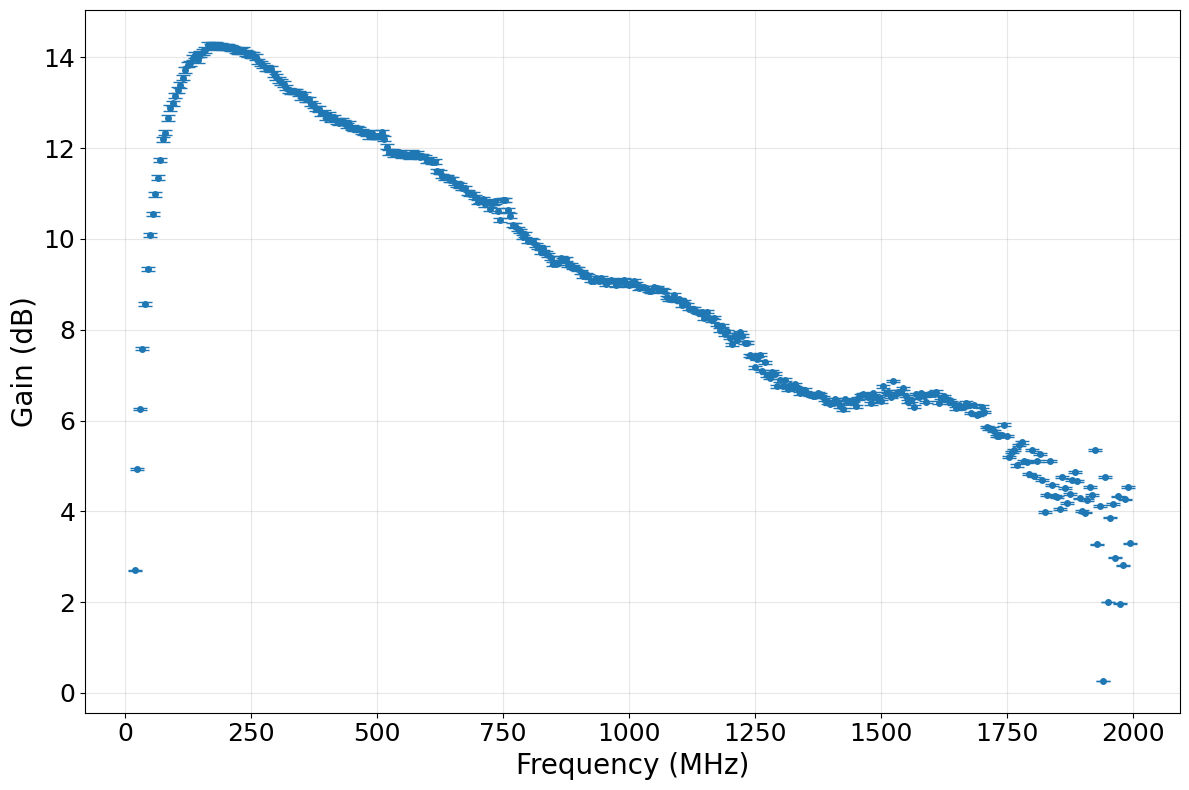

In [32]:
# Plot the gain spectrum with markers at the resampled frequencies

# Propagate the uncertainty from the hot and cold load temperatures to the gain uncertainty, using the formula:
gain_uncertainty = (LNA_thermo_resampled.g) * 1 / (300-77) 
LNA_thermo_resampled.plot_gain(fmt='o', markersize=4, yerr=gain_uncertainty, freq_range=(None, None), capsize=5)

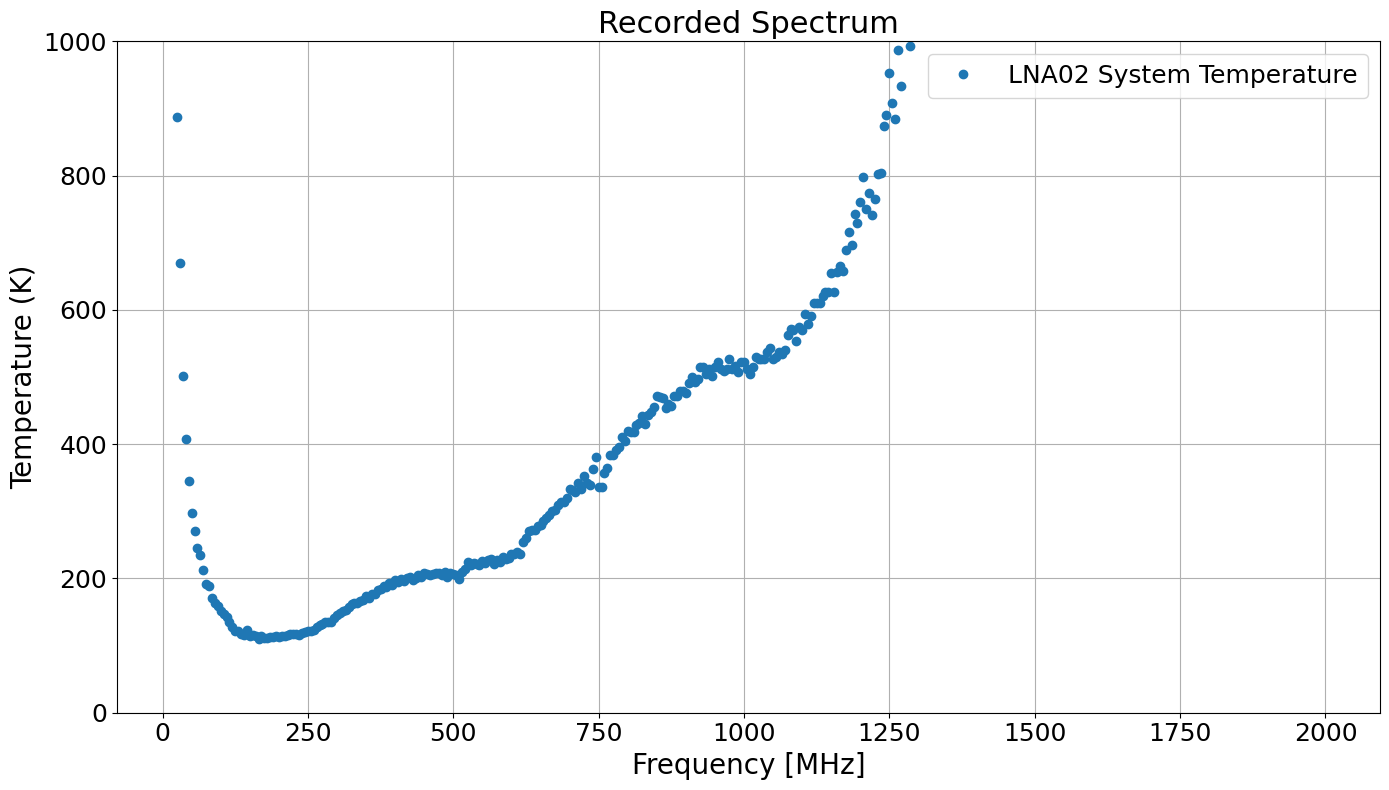

In [39]:
LNA_thermo_resampled.plot_system_temperature(marker='o', linestyle='', y_range=(0, 1000),
                                             marker_freqs=[50e6, 250e6, 1000e6])

From the measured power spectrum of the calibrators loads after LNA, we can infer their input temperature.

In [40]:
# Convert all measurements from dBm to kelvin for comparison
# and resample them to the same frequency grid
BB016_spec = LNA02_BB016.unit_convert('dBm', 'kelvin', channel_width=1e6, inplace=False).resample(new_frequency)
ND01_spec = LNA02_ND01.unit_convert('dBm', 'kelvin', channel_width=1e6, inplace=False).resample(new_frequency)

BB016_kelvin = LNA_thermo_resampled.infer_temperature(BB016_spec.despike(threshold=3), show_plot=False)
ND01_kelvin = LNA_thermo_resampled.infer_temperature(ND01_spec.despike(threshold=3), show_plot=False)

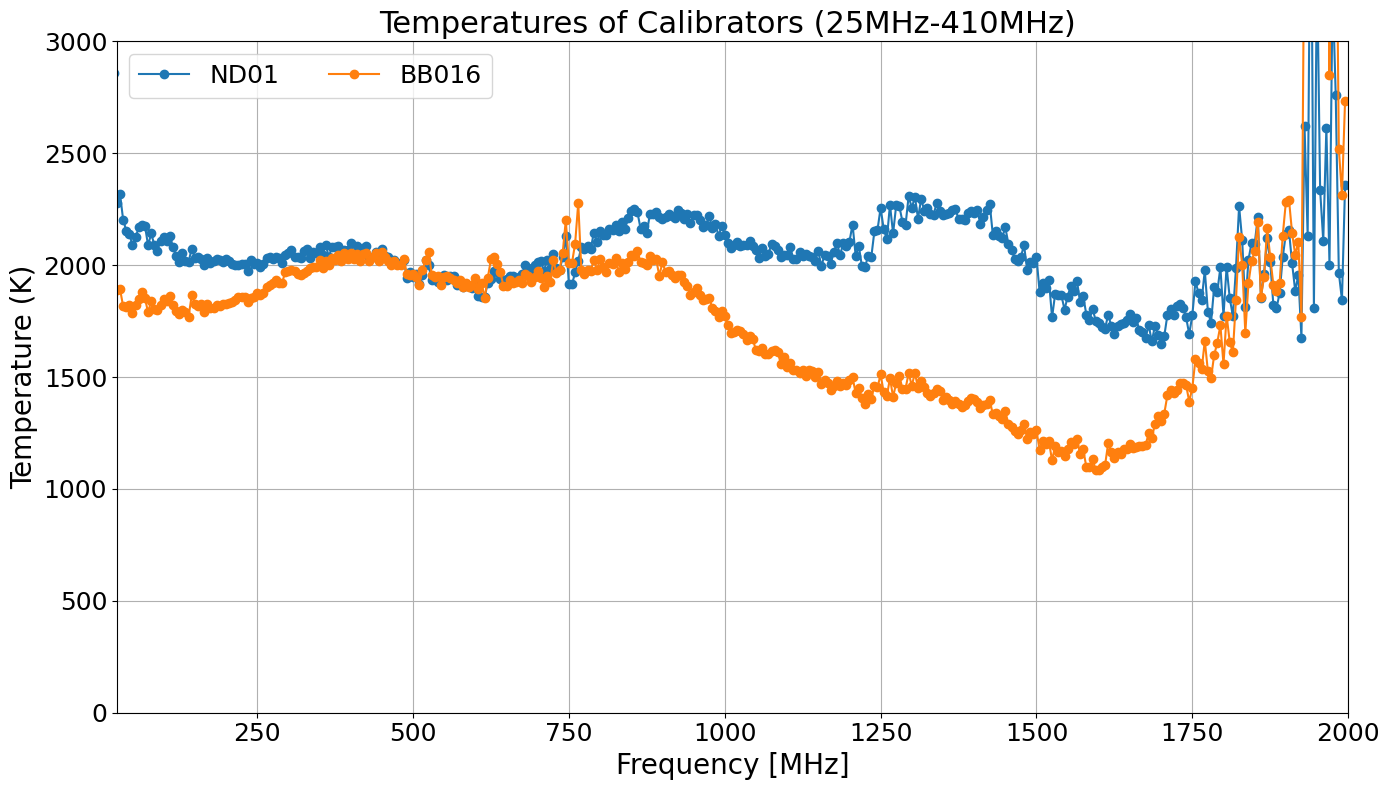

In [ ]:
plotter.plot_spectra([ND01_kelvin, BB016_kelvin], title='Temperatures of Calibrators (25MHz-410MHz) ',
                     ylabel='Temperature (K)', y_range=(0, 3000),
                     freq_range=(25, 1000), marker='o', linestyle='-',
                     save_path=None)